TODO:

    -[x] add column of "Max R difference vs homogeneous"
    -[x] add column of "Peak I diff vs homogeneous"
    -[x] update the plots to use the difference versions

In [8]:
import numpy as np
import json
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


cm = 1/2.54
DPI = 600

DATA_LOCATION =  '/Users/brendan/Documents/projects/hotspot/go/data/'
IMAGE_LOCATION = '/Users/brendan/Documents/projects/hotspot/writeup/images/'


EXTINCTION_CUTOFF = 50
TRIALS = 1000
N = 1000
SAVE_FIGS = False

## Plotting setup
blue_red_purple = ["#466be3","#be89f0", "#f74a64"]

colors = blue_red_purple
sns.set_style("ticks")
sns.set_palette(colors)
sns.color_palette()
sns.set_context("paper", rc={"font.size":12,"axes.titlesize":12,"axes.labelsize":12})   

In [9]:
with open(DATA_LOCATION + "R0Series1000.json") as file:
    json_file = json.load(file, parse_float=lambda f: round(float(f), 2))
    
R0Series = pd.json_normalize(
json_file,
record_path=["RunSets", "Runs"],
meta=[
    "RiskMean",
    "RiskVariance",
    "ProblemPlaceFraction",
    ["RunSets", "Parameters", "R0"],
    ["RunSets", "Parameters", "RunType"]
],
).drop(columns=["Is", "Rts", "EffectiveAlphas", "IRisks", "SRisks"])

R0Series["Extinction Probability"] = 1.0*(R0Series["FinalR"] <= EXTINCTION_CUTOFF)
R0Series["RiskMeanCat"] = pd.Categorical(R0Series["RiskMean"])



In [10]:
def theoretical_extinction(alpha_c, alpha_r, mean_p, N=1000):
    """
    Computes theoretical extinction probability.
    """
    a, b, p = alpha_c, alpha_r, mean_p # makes the equation a little easier to write
    upper_g = 1
    lower_g = 0
    for T in range(1000):
        g = (upper_g + lower_g)/2
        g_ = p*(((1 - p*b)*(1 - a) + (1 - (1-p*b)*(1-a))*g)**N) + (1 - p)*((1 - a + a * g)**N)
        if g_ < g:
            upper_g = g
        else:
            lower_g = g
    return g

start = 0.0
end = 8.0
step = 0.1
X = np.arange(start, end + step, step)


homogeneous_outbreak = []
for R0 in X:
    homogeneous_outbreak.append(1.0 - theoretical_extinction((R0)/N, 0, 0))

In [11]:
## Uses np.tile to replicate the control series
def tile(column):
    num_ppf = len(R0Series["ProblemPlaceFraction"].unique())
    return pd.Series(np.tile(R0Series[R0Series["ProblemPlaceFraction"] == 0][column], num_ppf))

R0Series["ExtinctionControl"] = tile("Extinction Probability")
R0Series["MaxIControl"] = tile("MaxI")
R0Series["FinalRControl"] =  tile("FinalR")

R0Series["FinalRDiff"] = R0Series["FinalR"] - R0Series["FinalRControl"]
R0Series["MaxIDiff"] = R0Series["MaxI"] - R0Series["MaxIControl"]
R0Series["Outbreak Probability"] = 1.0 - R0Series["Extinction Probability"]

In [12]:
control = R0Series[(R0Series["ProblemPlaceFraction"] == 0.0) & (R0Series["RunSets.Parameters.RunType"] == "simulation")]

In [13]:
Sim = R0Series[(R0Series["RunSets.Parameters.RunType"] == "simulation") & (R0Series["ProblemPlaceFraction"] != 0)]
DifEq = R0Series[(R0Series["RunSets.Parameters.RunType"] == "difeq") & (R0Series["ProblemPlaceFraction"] != 0)]
Difference = R0Series[(R0Series["RunSets.Parameters.RunType"] == "difference") & (R0Series["ProblemPlaceFraction"] != 0)]

In [14]:
column_names = {
    "RunSets.Parameters.R0": "R0",
    "ProblemPlaceFraction": "Hot Spot Fraction",
    "RiskVariance": "Risk Distribution Variance",
    "RiskMeanCat": "Risk Distribution Mean",
    "MaxIDiff": "Peak Size Difference",
    "FinalRDiff": "Extent Difference",
}

Sim = Sim.rename(columns=column_names)
control = control.rename(columns=column_names)

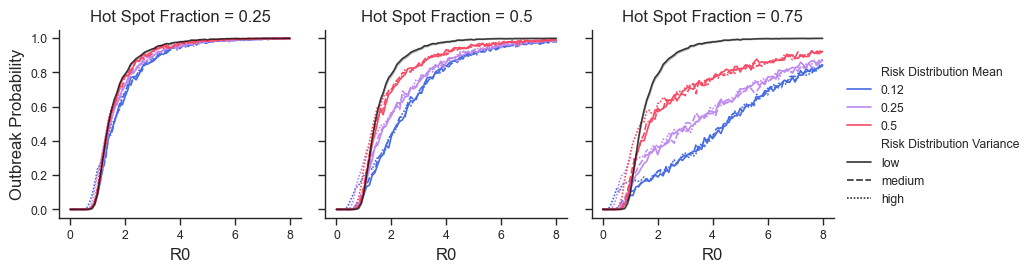

In [15]:
rp = sns.relplot(
    data=Sim,
    kind="line",
    errorbar=None,
    n_boot=None,
    y="Outbreak Probability",
    x="R0",
    col="Hot Spot Fraction",
    style="Risk Distribution Variance",
    hue="Risk Distribution Mean",
    height=11*cm*2/3,
    aspect=1.0,
)

for ax in rp.axes[0]:
    sns.lineplot(
        data=control,
        y="Outbreak Probability",
        x="R0",
        color="black",
        ax=ax,
        legend=None,
        alpha=0.7,
    )
#     sns.lineplot(
#         x=X,
#         y=homogeneous_extinction,
#         ax=ax,
#         color="green",
#         alpha=0.7,
#         legend=None,
#     )
if SAVE_FIGS:
    rp.savefig(IMAGE_LOCATION + "figure2A.png", dpi=DPI)

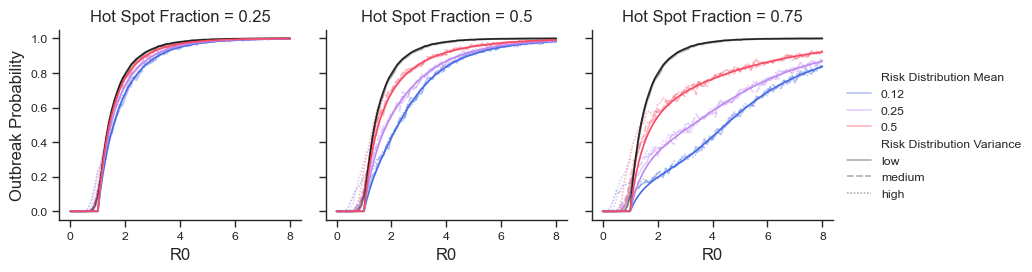

In [78]:
rp = sns.relplot(
    data=Sim,
    kind="line",
    errorbar=None,
    n_boot=None,
    y="Outbreak Probability",
    x="R0",
    col="Hot Spot Fraction",
    style="Risk Distribution Variance",
    hue="Risk Distribution Mean",
    alpha=0.4,
    height=11*cm*2/3,
    aspect=1.0,
)

# # add the homogeneous ABM case
# for ax in rp.axes[0]:
#     sns.lineplot(
#         data=control,
#         y="Extinction Probability",
#         x="R0",
#         color="black",
#         ax=ax,
#         legend=None,
#         alpha=0.4,
#     )


for pp, problem_place in enumerate([0.25, 0.5, 0.75]):
    
    ## Adds the ABM homogeneous case
    sns.lineplot(
        data=control,
        y="Outbreak Probability",
        x="R0",
        color="black",
        ax=rp.axes[0][pp],
        legend=None,
        alpha=0.4,
    )

    # Adds the theoretical line for homogeneous case
    sns.lineplot(
        x=X,
        y=homogeneous_outbreak,
        ax=rp.axes[0][pp],
        color="black",
        alpha=0.7,
        legend=None,
    )
    for rm, risk_mean in enumerate([0.125, 0.25, 0.5]): 
        Y = []
        for R0 in X:
            alpha_c = R0 / N * (1-problem_place)
            alpha_r = R0 / N * problem_place / risk_mean / risk_mean
            Y.append(1.0 - theoretical_extinction(alpha_c, alpha_r, risk_mean))
        sns.lineplot(
            x=X,
            y=Y,
            ax=rp.axes[0][pp],
            color=colors[rm],
            legend=None,
        )
rp.savefig(IMAGE_LOCATION + "figure2B.png", dpi=DPI)




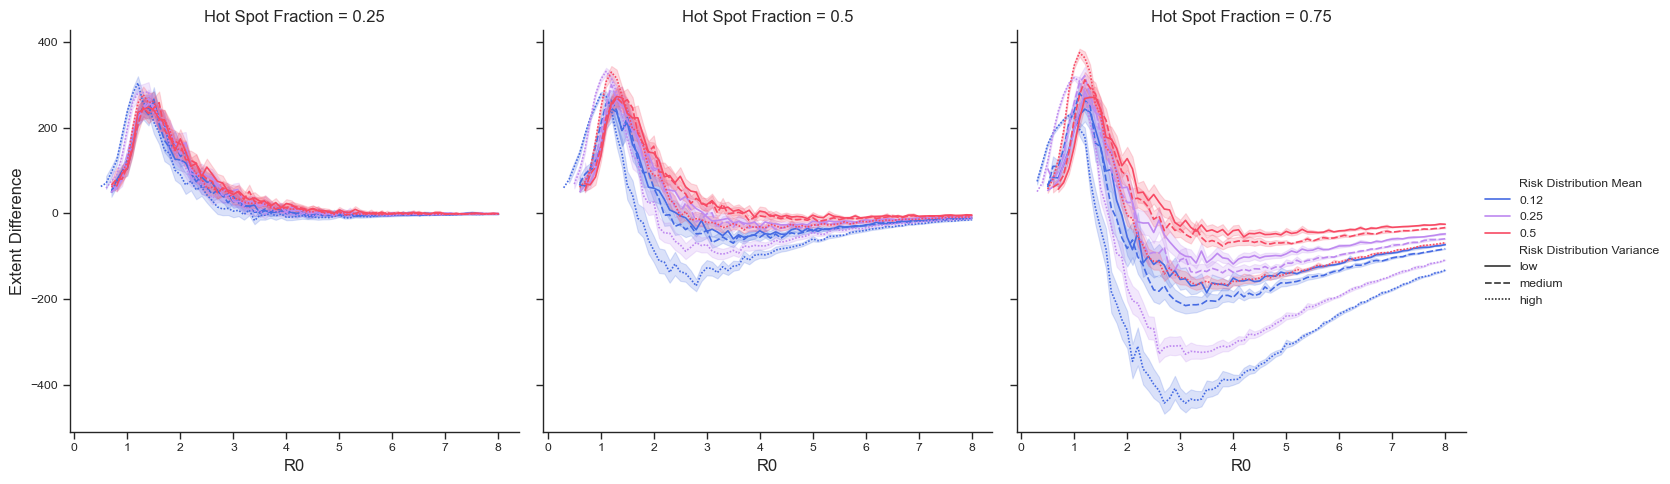

In [26]:
# sns.relplot(
#     data=DifEq,
#     kind="line",
#     y="FinalRDiff",
#     x="RunSets.Parameters.R0",
#     col="ProblemPlaceFraction",
#     style="RiskVariance",
#     hue="RiskMeanCat",
# ).savefig(IMAGE_LOCATION + "FinalR.png", dpi=DPI)


sns.relplot(
    data=Sim[Sim["Extinction Probability"] == 0],
    kind="line",
    y="Extent Difference",
    x="R0",
    col="Hot Spot Fraction",
    style="Risk Distribution Variance",
    hue="Risk Distribution Mean",
)#.savefig(IMAGE_LOCATION + "FinalRSim.png", dpi=DPI)


# sns.relplot(
#     data=Difference,
#     kind="line",
#     y="FinalRDiff",
#     x="RunSets.Parameters.R0",
#     col="ProblemPlaceFraction",
#     style="RiskVariance",
#     hue="RiskMeanCat",
# ).savefig(IMAGE_LOCATION + "FinalRDifference.png", dpi=DPI)


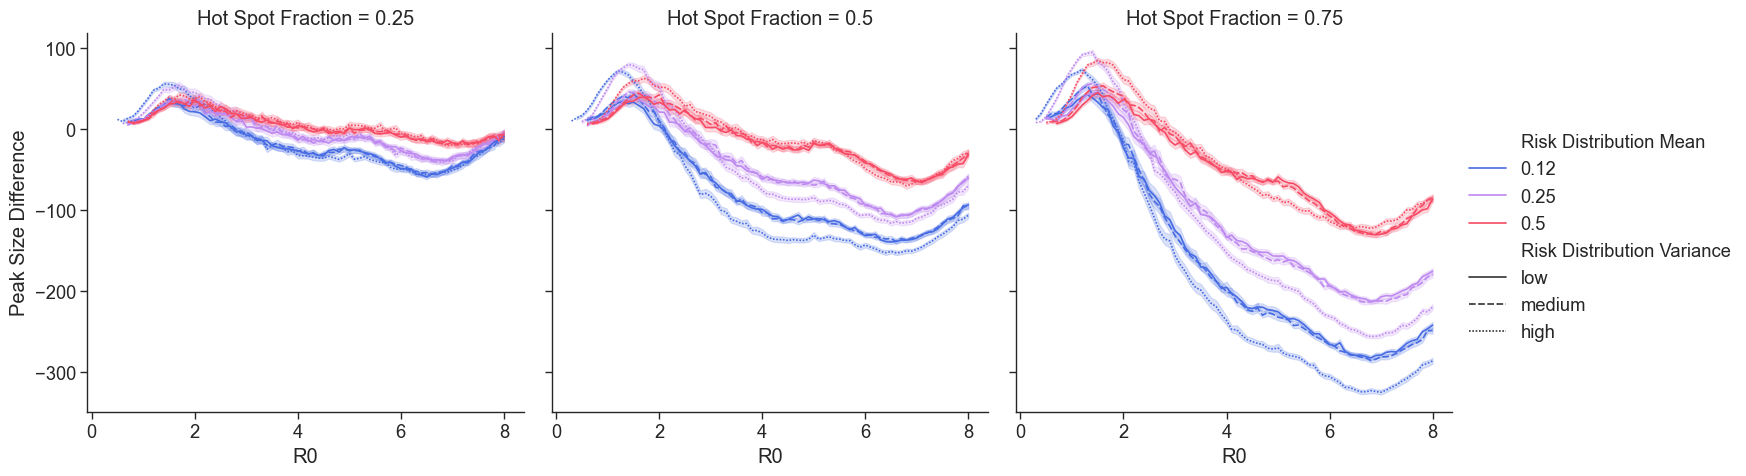

In [47]:
# sns.relplot(
#     data=DifEq,
#     kind="line",
#     y="MaxIDiff",
#     x="R0",
#     col="ProblemPlaceFraction",
#     style="RiskVariance",
#     hue="RiskMeanCat",
# ).savefig(IMAGE_LOCATION + "MaxI.png", dpi=DPI)

sns.relplot(
    data=Sim[Sim["Extinction Probability"] == 0],
    kind="line",
    y="Peak Size Difference",
    x="R0",
    col="Hot Spot Fraction",
    style="Risk Distribution Variance",
    hue="Risk Distribution Mean",
).savefig(IMAGE_LOCATION + "MaxISim.png", dpi=DPI)


# sns.relplot(
#     data=Difference[Difference["Extinction Probability"] == 0],
#     kind="line",
#     y="MaxIDiff",
#     x="R0",
#     col="ProblemPlaceFraction",
#     style="RiskVariance",
#     hue="RiskMeanCat",
# ).savefig(IMAGE_LOCATION + "MaxIDifference.png", dpi=DPI)

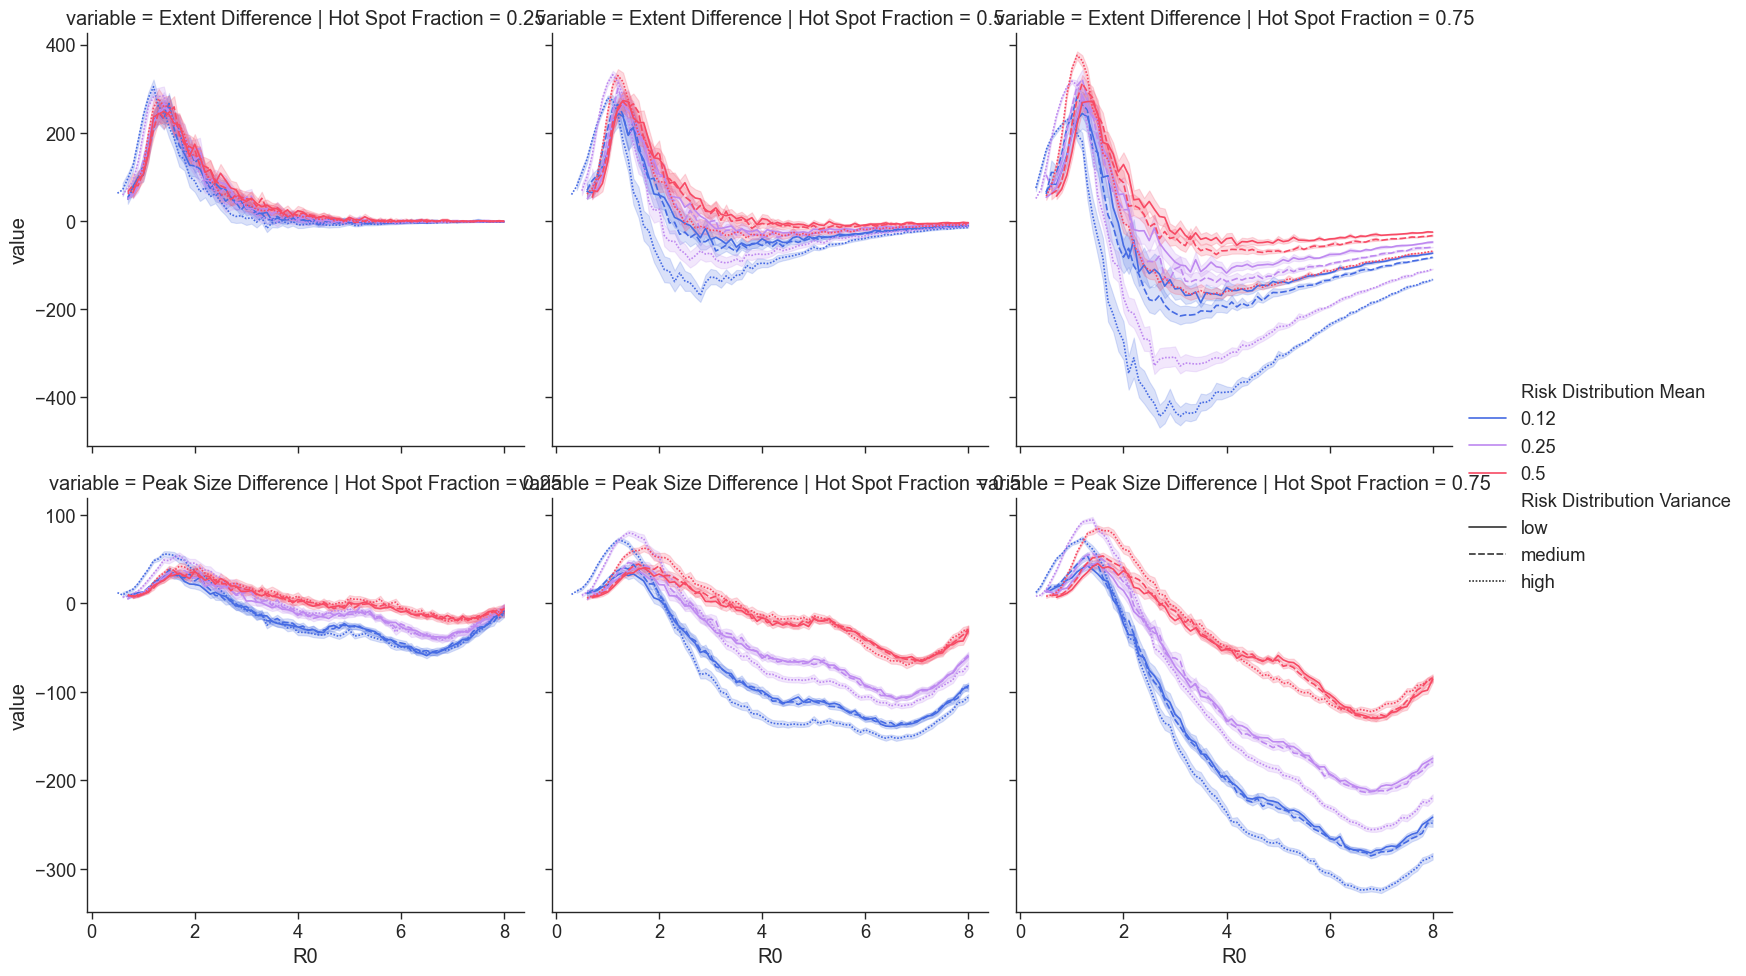

In [63]:
melt = pd.melt(Sim[Sim["Extinction Probability"] == 0], id_vars=['R0', 'Hot Spot Fraction', 'Risk Distribution Mean', 'Risk Distribution Variance'], 
                     value_vars=['Extent Difference', 'Peak Size Difference'],
                     var_name="variable", value_name="value")

outcome_plot = sns.relplot(
    data=melt,
    row="variable",
    y="value",
    x="R0",
    kind="line",
    col="Hot Spot Fraction",
    hue="Risk Distribution Mean",
    style="Risk Distribution Variance",
    facet_kws={"sharey":"row"})

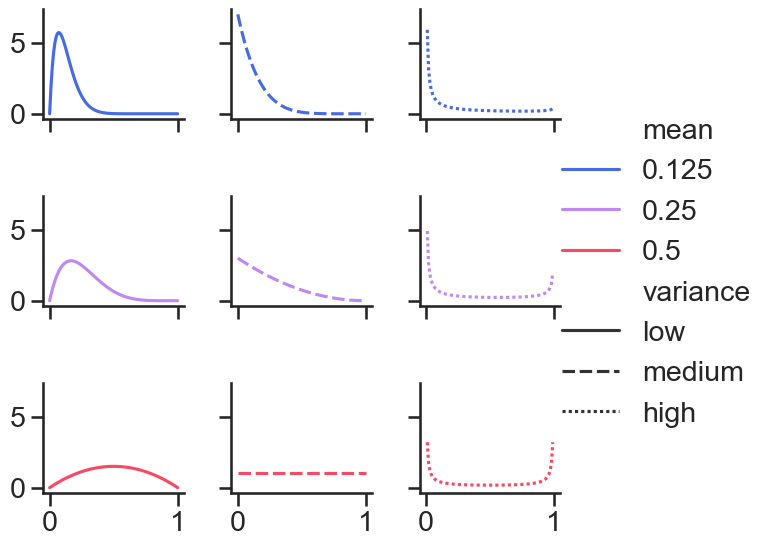

In [17]:
x = np.linspace(0, 1, 100)
bases = [(1, 7, 0.125), (1, 3, 0.25),  (1, 1, 0.5)]
factors = [(2, "low"), (1, "medium"), (0.1, "high")]



data = {
    "variance": [],
    "RiskMean": [],
    "ρ": [],
    "density": [],
}

for i, (a, b, base) in enumerate(bases):
    for j, (f, factor) in enumerate(factors):
        


        g = stats.beta(f*a, f*b)
        y = g.pdf(x)
        data["variance"].extend([factor]*len(y))
        data["RiskMean"].extend([base]*len(y))
        data["ρ"].extend(x)
        data["density"].extend(y)

distributions = pd.DataFrame(data)
distributions["mean"] = pd.Categorical(distributions["RiskMean"])
        

sns.set_context("talk", font_scale=1.25)
rel = sns.relplot(data=distributions,
            kind="line",
            x="ρ", y="density", row="mean",
            height=2.2,
            col="variance",
            hue="mean",
            style="variance")
rel.set_titles("")
rel.set(xlabel=None)
rel.set(ylabel=None)
#rel.savefig(IMAGE_LOCATION + "risk_distributions.png", dpi=DPI)

[Text(0, 0.5, 'Proportion')]

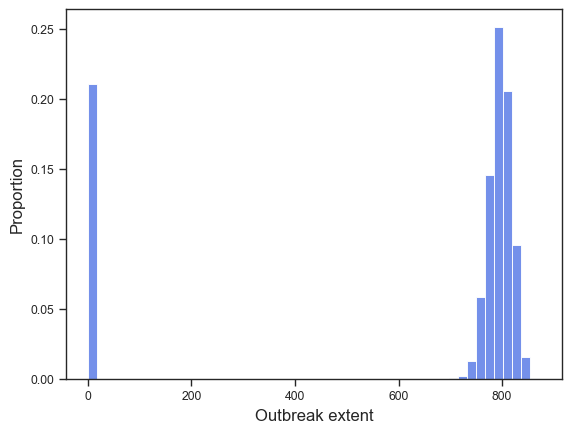

In [16]:
Homogeneous = R0Series[
    (R0Series["ProblemPlaceFraction"] == 0) &
    (R0Series["RunSets.Parameters.RunType"] == "simulation")
]

hist = sns.histplot(
    data=Homogeneous[Homogeneous["RunSets.Parameters.R0"] == 2.0],
    x="FinalR",
    stat="probability",
    bins=50,
    #height=2.2
)
hist.set(xlabel="Outbreak extent")
hist.set(ylabel="Proportion")
#hist.get_figure().savefig(IMAGE_LOCATION + "R2_histogram.png", dpi=DPI, bbox_inches='tight')


